The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.15.0


# Transformer
:label:`sec_transformer`

In previous chapters, we have covered major neural network architectures such as convolution neural networks (CNNs) and  recurrent neural networks (RNNs). Let us recap their pros and cons:

* **CNNs** are easy to parallelize at a layer but cannot capture the variable-length sequential dependency very well.

* **RNNs** are able to capture the long-range, variable-length sequential information, but suffer from inability to parallelize within a sequence.

To combine the advantages from both CNNs and RNNs, :cite:`Vaswani.Shazeer.Parmar.ea.2017` designed a novel architecture using the attention mechanism.
This architecture, which is called as *Transformer*, achieves parallelization by capturing recurrence sequence with attention and at the same time encodes each item's position in the sequence. As a result, Transformer leads to a compatible model with significantly shorter training time.

Similar to the seq2seq model in :numref:`sec_seq2seq`, Transformer is also based on the encoder-decoder architecture. However,  Transformer differs to the former by replacing the
recurrent layers in seq2seq with *multi-head attention* layers, incorporating the position-wise information through *position encoding*, and applying *layer normalization*.
We  compare  Transformer  and seq2seq  side-by-side in :numref:`fig_transformer`.

Overall, these two models are similar to each other: the source sequence embeddings are fed into $n$ repeated blocks. The outputs of the last block are then used as attention memory for the decoder.  The target sequence embeddings are similarly fed into $n$ repeated blocks in the decoder, and the final outputs are obtained by applying a dense layer with vocabulary size to the last block's outputs.

![The Transformer architecture.](http://d2l.ai/_images/transformer.svg)
:width:`500px`
:label:`fig_transformer`


On the flip side, Transformer differs from the seq2seq with attention model in the following:

1. **Transformer block**: a recurrent layer in seq2seq is replaced by a *Transformer block*. This block contains a *multi-head attention* layer and a *position-wise feed-forward network* with two layers for the encoder. For the decoder, another multi-head attention layer is used to take the encoder state.
1. **Add and norm**: the inputs and outputs of both the multi-head attention layer or the position-wise feed-forward network, are processed by two "add and norm" layer that contains a residual structure and a *layer normalization* layer.
1. **Position encoding**: since the self-attention layer does not distinguish the item order in a sequence, a positional encoding layer is used to add sequential information into each sequence item.


In the rest of this section, we will equip you with each new component introduced by Transformer, and get you up and running to construct a machine translation model.


In [1]:
from d2l import torch as d2l
import math
import torch
from torch import nn

## Multi-Head Attention

Before the discussion of the *multi-head attention* layer, let us quick express the *self-attention* architecture. The self-attention model is a normal attention model, with its query, its key, and its value being copied exactly the same from each item of the sequential inputs. As we illustrate in :numref:`fig_self_attention`, self-attention outputs a same-length sequential output for each input item. Compared with a recurrent layer, output items of a self-attention layer can be computed in parallel and, therefore, it is easy to obtain a highly-efficient implementation.

![Self-attention architecture.](../img/self-attention.svg)
:label:`fig_self_attention`


The *multi-head attention* layer consists of $h$ parallel self-attention layers, each one is called a *head*. For each head, before feeding into the attention layer, we project the queries, keys, and values with three dense layers with hidden sizes $p_q$, $p_k$, and $p_v$, respectively. The outputs of these $h$ attention heads are concatenated and then processed by a final dense layer.


![Multi-head attention](../img/multi-head-attention.svg)


Assume that the dimension for a query, a key, and a value are $d_q$, $d_k$, and $d_v$, respectively. Then, for each head $i=1,\ldots, h$, we can train learnable parameters
$\mathbf W_q^{(i)}\in\mathbb R^{p_q\times d_q}$,
$\mathbf W_k^{(i)}\in\mathbb R^{p_k\times d_k}$,
and $\mathbf W_v^{(i)}\in\mathbb R^{p_v\times d_v}$. Therefore, the output for each head is

$$\mathbf o^{(i)} = \mathrm{attention}(\mathbf W_q^{(i)}\mathbf q, \mathbf W_k^{(i)}\mathbf k,\mathbf W_v^{(i)}\mathbf v),$$

where $\textrm{attention}$ can be any attention layer, such as the `DotProductAttention` and `MLPAttention` as we introduced in :numref:`sec_attention`.



After that, the output with length $p_v$ from each of the $h$ attention heads are concatenated to be an output of length $h p_v$, which is then passed the final dense layer with $d_o$ hidden units. The weights of this dense layer can be denoted by $\mathbf W_o\in\mathbb R^{d_o\times h p_v}$. As a result, the multi-head attention output will be

$$\mathbf o = \mathbf W_o \begin{bmatrix}\mathbf o^{(1)}\\\vdots\\\mathbf o^{(h)}\end{bmatrix}.$$


Now we can implement the multi-head attention. Assume that the multi-head attention contain the number heads `num_heads` $=h$, the hidden size `num_hiddens` $=p_q=p_k=p_v$ are the same for the query,  key, and value dense layers. In addition, since the multi-head attention keeps the same dimensionality between its input and its output, we have the output feature size $d_o =$ `num_hiddens` as well.


In [2]:
#@save
class MultiHeadAttention(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, query, key, value, valid_len):
        # For self-attention, `query`, `key`, and `value` shape:
        # (`batch_size`, `seq_len`, `dim`), where `seq_len` is the length of
        # input sequence. `valid_len` shape is either (`batch_size`, ) or
        # (`batch_size`, `seq_len`).

        # Project and transpose `query`, `key`, and `value` from
        # (`batch_size`, `seq_len`, `num_hiddens`) to
        # (`batch_size` * `num_heads`, `seq_len`, `num_hiddens` / `num_heads`)
        query = transpose_qkv(self.W_q(query), self.num_heads)
        key = transpose_qkv(self.W_k(key), self.num_heads)
        value = transpose_qkv(self.W_v(value), self.num_heads)

        if valid_len is not None:
            valid_len = torch.repeat_interleave(
                valid_len, repeats=self.num_heads, dim=0)

        # For self-attention, `output` shape:
        # (`batch_size` * `num_heads`, `seq_len`, `num_hiddens` / `num_heads`)
        output = self.attention(query, key, value, valid_len)

        # `output_concat` shape: (`batch_size`, `seq_len`, `num_hiddens`)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

Here are the definitions of the transpose functions `transpose_qkv` and `transpose_output`, which are the inverse of each other.


In [3]:
#@save
def transpose_qkv(X, num_heads):
    # Input `X` shape: (`batch_size`, `seq_len`, `num_hiddens`).
    # Output `X` shape:
    # (`batch_size`, `seq_len`, `num_heads`, `num_hiddens` / `num_heads`)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # `X` shape:
    # (`batch_size`, `num_heads`, `seq_len`, `num_hiddens` / `num_heads`)
    X = X.permute(0, 2, 1, 3)

    # `output` shape:
    # (`batch_size` * `num_heads`, `seq_len`, `num_hiddens` / `num_heads`)
    output = X.reshape(-1, X.shape[2], X.shape[3])
    return output


#@save
def transpose_output(X, num_heads):
    # A reversed version of `transpose_qkv`
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

Let us test the `MultiHeadAttention` model in a toy example. Create a multi-head attention with the hidden size $d_o = 100$, the output will share the same batch size and sequence length as the input, but the last dimension will be equal to the `num_hiddens` $= 100$.


In [4]:
cell = MultiHeadAttention(5, 5, 5, 100, 10, 0.5)
cell.eval()
X = torch.ones((2, 4, 5))
valid_len = torch.tensor([2, 3])
cell(X, X, X, valid_len).shape

torch.Size([2, 4, 100])

## Position-wise Feed-Forward Networks

Another key component in the Transformer block is called *position-wise feed-forward network (FFN)*. It accepts a $3$-dimensional input with shape (batch size, sequence length, feature size). The position-wise FFN consists of two dense layers that applies to the last dimension. Since the same two dense layers are used for each position item in the sequence, we referred to it as *position-wise*. Indeed, it is equivalent to applying two $1 \times 1$ convolution layers.

Below, the `PositionWiseFFN` shows how to implement a position-wise FFN with two dense layers of hidden size `ffn_num_hiddens` and `pw_num_outputs`, respectively.


In [5]:
#@save
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_input, ffn_num_hiddens, pw_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, pw_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

Similar to the multi-head attention, the position-wise feed-forward network will only change the last dimension size of the input---the feature dimension. In addition, if two items in the input sequence are identical, the according outputs will be identical as well.


In [6]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[ 0.5052,  0.5868, -0.2130,  0.2876,  0.3928, -0.2516, -0.1646,  0.2217],
        [ 0.5052,  0.5868, -0.2130,  0.2876,  0.3928, -0.2516, -0.1646,  0.2217],
        [ 0.5052,  0.5868, -0.2130,  0.2876,  0.3928, -0.2516, -0.1646,  0.2217]],
       grad_fn=<SelectBackward>)

## Add and Norm

Besides the above two components in the Transformer block, the "add and norm" within the block also plays a key role to connect the inputs and outputs of other layers smoothly. To explain, we add a layer that contains a residual structure and a *layer normalization* after both the multi-head attention layer and the position-wise FFN network. *Layer normalization* is similar to batch normalization in :numref:`sec_batch_norm`. One difference is that the mean and variances for the layer normalization are calculated along the last dimension, e.g `X.mean(axis=-1)` instead of the first batch dimension, e.g., `X.mean(axis=0)`. Layer normalization prevents the range of values in the layers from changing too much, which allows faster training and better generalization ability.


PyTorch has both `LayerNorm` and `BatchNorm1d` implemented within the `nn` module. Let us call both of them and see the difference in the example below.


In [7]:
layer = nn.LayerNorm(2)
batch = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# Compute mean and variance from `X` in the training mode
print('layer norm:', layer(X), '\nbatch norm:', batch(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward>)


Now let us implement the connection block `AddNorm` together. `AddNorm` accepts two inputs $X$ and $Y$. We can deem $X$ as the original input in the residual network, and $Y$ as the outputs from either the multi-head attention layer or the position-wise FFN network. In addition, we apply dropout on $Y$ for regularization.


In [8]:
#@save
class AddNorm(nn.Module):
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

Due to the residual connection, $X$ and $Y$ should have the same shape.


In [9]:
add_norm = AddNorm([3,4], 0.5) # normalized_shape is input.size()[1:]
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

## Positional Encoding

Unlike the recurrent layer, both the multi-head attention layer and the position-wise feed-forward network compute the output of each item in the sequence independently. This feature enables us to parallelize the computation, but it fails to model the sequential information for a given sequence. To better capture the sequential information, the Transformer model uses the *positional encoding* to maintain the positional information of the input sequence.

To explain, assume that $X\in\mathbb R^{l\times d}$ is the embedding of an example, where $l$ is the sequence length and $d$ is the embedding size. This positional encoding layer encodes $X$'s position $P\in\mathbb R^{l\times d}$ and outputs $P+X$.

The position $P$ is a 2-D matrix, where $i$ refers to the order in the sentence, and $j$ refers to the position along the embedding vector dimension. In this way, each value in the origin sequence is then maintained using the equations below:

$$P_{i, 2j} = \sin(i/10000^{2j/d}),$$

$$\quad P_{i, 2j+1} = \cos(i/10000^{2j/d}),$$

for $i=0,\ldots, l-1$ and $j=0,\ldots,\lfloor(d-1)/2\rfloor$.


:numref:`fig_positional_encoding` illustrates the positional encoding.

![Positional encoding.](../img/positional-encoding.svg)
:label:`fig_positional_encoding`


In [10]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough `P`
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(0, max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

Now we test the `PositionalEncoding` class with a toy model for 4 dimensions. As we can see, the $4^{\mathrm{th}}$ dimension has the same frequency as the $5^{\mathrm{th}}$ but with different offset (i.e. phase) because one is produced by a sine function and the other is produced by a cosine function. The $6^{\mathrm{th}}$ and $7^{\mathrm{th}}$ dimensions have lower frequency.


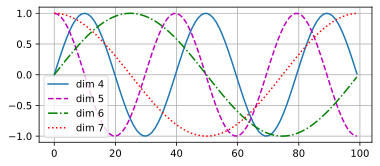

In [11]:
pe = PositionalEncoding(20, 0)
pe.eval()
Y = pe(torch.zeros((1, 100, 20)))
d2l.plot(torch.arange(100), Y[0, :, 4:8].T, figsize=(6, 2.5),
         legend=["dim %d" % p for p in [4, 5, 6, 7]])

## Encoder

Armed with all the essential components of Transformer, let us first build a Transformer encoder block. This encoder contains a multi-head attention layer, a position-wise feed-forward network, and two "add and norm" connection blocks. As shown in the code, for both of the attention model and the positional FFN model in the `EncoderBlock`, their outputs' dimension are equal to the `num_hiddens`. This is due to the nature of the residual block, as we need to add these outputs back to the original value during "add and norm".


In [12]:
#@save
class EncoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(key_size, query_size, value_size,
                                            num_hiddens, num_heads, dropout,
                                            use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_len):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_len))
        return self.addnorm2(Y, self.ffn(Y))

Due to the residual connections, this block will not change the input shape. It means that the `num_hiddens` argument should be equal to the input size of the last dimension. In our toy example below,  `num_hiddens` $= 24$, `ffn_num_hiddens` $=48$, `num_heads` $= 8$, and `dropout` $= 0.5$.


In [13]:
X = torch.ones((2, 100, 24))
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_len).shape

torch.Size([2, 100, 24])

Now it comes to the implementation of the entire Transformer encoder. With the Transformer encoder, $n$ blocks of `EncoderBlock` stack up one after another. Because of the residual connection, the embedding layer size $d$ is same as the Transformer block output size. Also note that we multiply the embedding output by $\sqrt{d}$ to prevent its values from being too small.


In [14]:
#@save
class TransformerEncoder(d2l.Encoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_len, *args):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        for blk in self.blks:
            X = blk(X, valid_len)
        return X

Let us create an encoder with two stacked  Transformer encoder blocks, whose hyperparameters are the same as before. Similar to the previous toy example's parameters, we add two more parameters `vocab_size` to be $200$ and `num_layers` to be $2$ here.


In [15]:
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_len).shape

torch.Size([2, 100, 24])

## Decoder

The Transformer decoder block looks similar to the Transformer encoder block. However, besides the two sub-layers (the multi-head attention layer and the positional encoding network), the decoder Transformer block contains a third sub-layer, which applies multi-head attention on the output of the encoder stack. Similar to the  Transformer encoder block, the  Transformer decoder block employs "add and norm", i.e., the residual connections and the layer normalization to connect each of the sub-layers.

To be specific, at time step $t$, assume that $\mathbf x_t$ is the current input, i.e., the query. As illustrated in :numref:`fig_self_attention_predict`, the keys and values of the self-attention layer consist of the current query with all the past queries $\mathbf x_1, \ldots, \mathbf x_{t-1}$.

![Predict at time step $t$ for a self-attention layer.](../img/self-attention-predict.svg)
:label:`fig_self_attention_predict`

During training, the output for the $t$-query could observe all the previous key-value pairs. It results in an different behavior from prediction. Thus, during prediction we can eliminate the unnecessary information by specifying the valid length to be $t$ for the $t^\textrm{th}$ query.


In [16]:
class DecoderBlock(nn.Module):
    # `i` means it is the i-th block in the decoder
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = MultiHeadAttention(key_size, query_size, value_size,
                                             num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = MultiHeadAttention(key_size, query_size, value_size,
                                             num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_len = state[0], state[1]
        # `state[2][i]` contains the past queries for this block
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, seq_len, _ = X.shape
            # Shape: (batch_size, seq_len), the values in the j-th column
            # are j+1
            valid_len = torch.repeat_interleave(torch.arange(
                1, seq_len + 1, device=X.device), batch_size, dim=0)
            # Convert valid_len to 2D
            if valid_len.shape[0]!=X.shape[0]:
                valid_len = valid_len.reshape(-1, X.shape[1])
        else:
            valid_len = None

        X2 = self.attention1(X, key_values, key_values, valid_len)
        Y = self.addnorm1(X, X2)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_len)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

Similar to the  Transformer encoder block, `num_hiddens` should be equal to the last dimension size of $X$.


In [17]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_len), valid_len, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

The construction of the entire  Transformer decoder is identical to the  Transformer encoder, except for the additional dense layer to obtain the output confidence scores.

Let us implement the  Transformer decoder `TransformerDecoder`. Besides the regular hyperparameters such as the `vocab_size` and `num_hiddens`, the  Transformer decoder also needs the Transformer encoder's outputs `enc_outputs` and `env_valid_len`.


In [18]:
class TransformerDecoder(d2l.Decoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, env_valid_len, *args):
        return [enc_outputs, env_valid_len, [None]*self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        for blk in self.blks:
            X, state = blk(X, state)
        return self.dense(X), state

## Training

Finally, we can build an encoder-decoder model with the Transformer architecture.
Similar to the seq2seq with attention model in :numref:`sec_seq2seq_attention`, we use the following hyperparameters: two Transformer blocks with both the embedding size and the block output size to be $32$. In addition, we use $4$ heads, and set the hidden size to be twice larger than the output size.


loss 0.019, 4824.0 tokens/sec on cuda:0


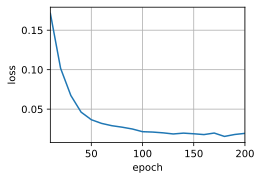

In [19]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)
d2l.train_s2s_ch9(model, train_iter, lr, num_epochs, tgt_vocab, device)

As we can see from the training time and accuracy, compared with the seq2seq model with attention model, Transformer runs faster per epoch, and converges faster at the beginning.

We can use the trained Transformer to translate some simple sentences.


In [20]:
engs = ['go .', "i lost .", 'i\'m home .', 'he\'s calm .']
fras = ['va !', 'j\'ai perdu .', 'je suis chez moi .', 'il est calme .']
d2l.translate(engs, fras, model, src_vocab, tgt_vocab, num_steps, device)

go . => <unk> le chercher !, bleu 0.000
i lost . => j'ai gagné ., bleu 0.000


i'm home . => je suis chez moi va , les ., bleu 0.640
he's calm . => <unk> ., bleu 0.000


## Summary

* The Transformer model is based on the encoder-decoder architecture.
* Multi-head attention layer contains $h$ parallel attention layers.
* Position-wise feed-forward network consists of two dense layers that apply to the last dimension.
* Layer normalization differs from batch normalization by normalizing along the last dimension (the feature dimension) instead of the first (batch size) dimension.
* Positional encoding is the only place that adds positional information to the Transformer model.


## Exercises

1. Try a larger size of epochs and compare the loss between seq2seq model and Transformer model.
1. Can you think of any other benefit of positional encoding?
1. Compare layer normalization and batch normalization, when shall we apply which?


[Discussions](https://discuss.d2l.ai/t/1066)
